<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

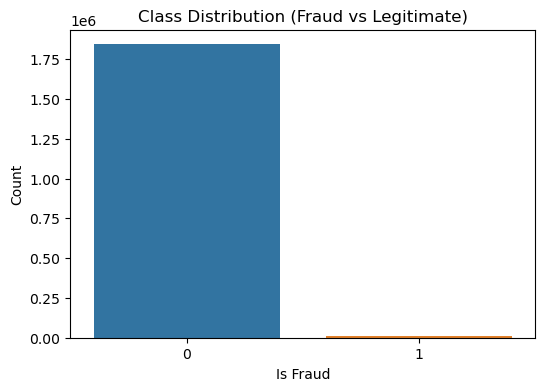

Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    368526
           1       0.07      0.76      0.12      1953

    accuracy                           0.94    370479
   macro avg       0.53      0.85      0.55    370479
weighted avg       0.99      0.94      0.97    370479

Confusion Matrix:
 [[347570  20956]
 [   463   1490]]
AUC-ROC Score: 0.8530322271196334
--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.58      0.70      0.64      1953

    accuracy                           1.00    370479
   macro avg       0.79      0.85      0.82    370479
weighted avg       1.00      1.00      1.00    370479

Confusion Matrix:
 [[367531    995]
 [   577   1376]]
AUC-ROC Score: 0.8509285732334116
--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv(r"C:\Users\kanni\Downloads\archive (1)\fraudTrain.csv")
df_test = pd.read_csv(r"C:\Users\kanni\Downloads\archive (1)\fraudTest.csv")

df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(df_combined.info())

plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_combined)
plt.title('Class Distribution (Fraud vs Legitimate)')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

categorical_cols = df_combined.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_combined[col] = LabelEncoder().fit_transform(df_combined[col])

if 'datetime_column' in df_combined.columns:
    df_combined['datetime_column'] = pd.to_datetime(df_combined['datetime_column'])
    df_combined['timestamp'] = df_combined['datetime_column'].apply(lambda x: x.timestamp())
    df_combined.drop(columns=['datetime_column'], inplace=True)

scaler = StandardScaler()
numeric_cols = df_combined.select_dtypes(include=['number']).columns
df_combined[numeric_cols] = scaler.fit_transform(df_combined[numeric_cols])

X = df_combined.drop(columns=['is_fraud'])
y = df_combined['is_fraud']

if y.dtype != 'int' and y.dtype != 'bool':
    y = pd.Categorical(y).codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))
    print("-" * 50)

best_model = models["Random Forest"]
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC (Random Forest): {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(top_n), importances[indices][:top_n], align='center')
plt.yticks(range(top_n), X.columns[indices][:top_n])
plt.xlabel("Feature Importance")
plt.show()
